In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import re

In [2]:
learning_rate = 0.003
meta_step_size = 0.25

inner_batch_size = 25
eval_batch_size = 25

meta_iters = 1500
eval_iters = 5
inner_iters = 4

eval_interval = 2
train_shots = 500
shots = 100
classes = 3


In [3]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [4]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 15)                765       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 128       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 27        
Total params: 48,191,520
Trainable params: 48,191,520
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [6]:
!gdown --id 19YGQcsH5IHCf2AOMn5v6gwsb9cmo1IRf
!gdown --id 1An_uo6EU7pFPeedUCOkQNcYTXsM2Bl9n
!gdown --id 1abFkFGOl-1Ch-fEzYwBcs12b-Vk_5w-k
!gdown --id 1-Qdu-WAuSGAhl5U27xpFRAu7r5EfG5Bh

Downloading...
From: https://drive.google.com/uc?id=19YGQcsH5IHCf2AOMn5v6gwsb9cmo1IRf
To: /content/Dataset_IMDB.csv
22.1MB [00:00, 83.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1An_uo6EU7pFPeedUCOkQNcYTXsM2Bl9n
To: /content/financial-news-all-data.csv
100% 672k/672k [00:00<00:00, 10.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1abFkFGOl-1Ch-fEzYwBcs12b-Vk_5w-k
To: /content/labeledTrainData.tsv
33.6MB [00:00, 205MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-Qdu-WAuSGAhl5U27xpFRAu7r5EfG5Bh
To: /content/Tweets.csv
3.42MB [00:00, 30.2MB/s]


In [7]:
def imdb_to_sentiment(rating):
  rating = float(rating)
  if rating <0.5:
    return 0
  elif 0.5 <= rating <= 0.6:
    return 1
  else: 
    return 2

def sent_to_label(sentiment):
  class_names = ['negative', 'neutral', 'positive']
  return class_names.index(sentiment)

def remove_at(sample):
  return re.sub(r"@\S+", "", sample)

In [8]:
RANDOM_SEED = 42

In [9]:
def document_reader():
  dataframe = []
  
  # data@1
  df = pd.read_csv("Dataset_IMDB.csv")
  df['sentiment'] = df.Rating.apply(imdb_to_sentiment)
  df = df.rename(columns={'Text': 'Content'})
  dataframe.append(df)
  # data@2
  df = pd.read_csv("financial-news-all-data.csv", encoding = "cp1252")
  df.columns = ['sentiment_temp', 'content']
  df['sentiment'] = df.sentiment_temp.apply(sent_to_label)
  df['content'] = df.content.apply(lambda x: x.lower ())
  negative_rv = df[df.sentiment_temp=='negative']
  negative_rv = negative_rv.reset_index(drop=True)
  neutral_rv = df[df.sentiment_temp=='neutral']
  neutral_rv = neutral_rv.sample(n=len(negative_rv), random_state=RANDOM_SEED)
  neutral_rv = neutral_rv.reset_index(drop=True)
  reviews = df[df.sentiment_temp=='positive'].append(negative_rv)
  reviews = reviews.append(neutral_rv).reset_index(drop=True)
  reviews = reviews.rename(columns={'content': 'Content'})
  dataframe.append(reviews)
  #data@3
  df = pd.read_csv("Tweets.csv")
  df['sentiment'] = df.airline_sentiment.apply(sent_to_label)
  df['Content'] = df.text.apply(remove_at)
  negative_rv = df[df.sentiment==0]
  negative_rv = negative_rv.reset_index(drop=True)
  neutral_rv = df[df.sentiment==1]
  negative_rv = negative_rv.sample(n=len(neutral_rv), random_state=RANDOM_SEED)
  neutral_rv = neutral_rv.reset_index(drop=True)
  reviews = df[df.sentiment==2].append(negative_rv)
  reviews = reviews.append(neutral_rv).reset_index(drop=True)
  dataframe.append(reviews)
  #data@4
  df = pd.read_csv("labeledTrainData.tsv", sep='\t')
  df = df.rename(columns={'review': 'Content'})
  dataframe.append(df)

  return dataframe


In [10]:
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

In [11]:
ds = document_reader()

In [12]:
class Dataset:
  def __init__(self, mode = 'Training'):
    self.ds = document_reader()
    self.data = {}
    self.counter = -1
    self.training = True if mode == 'Training' else False
    self.length = len(self.ds)
  
  def get_mini_dataset(self, batch_size, shots=100, split=False):
    if self.training:
      self.counter += 1
      self.counter = self.counter%self.length
    # else:
    #   self.counter = self.length-1
    
    train_reviews, test_reviews, y_train, y_test =\
    train_test_split(
    self.ds[self.counter].Content,
    self.ds[self.counter].sentiment,
    test_size=shots,
    train_size=200,
    random_state=RANDOM_SEED
    )
    # print(len(test_reviews), len(y_test))
    y_train = np.array(y_train,dtype=np.float)
    y_test = np.array(y_test,dtype=np.float)
    train_dataset = tf.data.Dataset.from_tensor_slices((train_reviews, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_reviews, y_test))
    train_dataset = train_dataset.shuffle(len(train_reviews)).batch(batch_size)
    test_dataset = test_dataset.shuffle(len(test_reviews)).batch(100)
    if split:
      return train_dataset, test_dataset
    return train_dataset


In [13]:
train_dataset = Dataset('Training')
del train_dataset.ds[3]
train_dataset.length = 3
test_dataset = Dataset('testing')
test_dataset.ds = [test_dataset.ds[3]]
test_dataset.length = 1

In [14]:
for i in range(3):
  print(train_dataset.ds[i].head())
print(test_dataset.ds[0].head())

      Id                                            Content  ... Rating  sentiment
0  29420  In my opinion, a movie reviewer's most importa...  ...    0.1          0
1  17219  STARSHIP TROOPERS (director: Paul Verhoeven; c...  ...    0.2          0
2  18406  THE SCHOOL OF FLESH (ECOLE DE lA CHAIR, L') (D...  ...    0.2          0
3  18648  LOCK, STOCK AND TWO SMOKING BARRELS (director:...  ...    0.2          0
4  20021  RUN LOLA RUN (LOLA RENNT)(director/writer: Tom...  ...    0.2          0

[5 rows x 5 columns]
  sentiment_temp                                            Content  sentiment
0       positive  with the new production plant the company woul...          2
1       positive  according to the company 's updated strategy f...          2
2       positive  financing of aspocomp 's growth aspocomp is ag...          2
3       positive  for the last quarter of 2010 , componenta 's n...          2
4       positive  in the third quarter of 2010 , net sales incre...          2
      

In [15]:
training = []
testing = []
scores = []
for meta_iter in range(meta_iters):
  frac_done = meta_iters/meta_iters
  cur_meta_step_size = (1 - frac_done) * meta_step_size
  old_vars = model.get_weights()
  mini_dataset = train_dataset.get_mini_dataset(1)
  for text, labels in mini_dataset:
    with tf.GradientTape() as tape:
      preds = model(text)
      loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
  new_vars = model.get_weights()

  for var in range(len(new_vars)):
    new_vars[var] = old_vars[var] + ((new_vars[var] - old_vars[var])* cur_meta_step_size)
  model.set_weights(new_vars)
  if meta_iter % eval_interval == 0:
    accuracies = []
    for dataset in (train_dataset, test_dataset):
      train_set, test_set = dataset.get_mini_dataset(1, 100, True)
      old_vars = model.get_weights()

      for text, labels in train_set:
        with tf.GradientTape() as tape:
          preds = model(text)
          loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
      for text, lab in test_set:
        test_preds = model.predict(text)
        test_preds = np.argmax(test_preds, axis=1)
        num_correct = sum(test_preds == lab.numpy())
        accuracies.append(num_correct/len(test_preds))
      model.set_weights(old_vars)
    training.append(accuracies[0])
    testing.append(accuracies[1])
    if meta_iter % 100 == 0:
      print("batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1]))
      # print("testing ")
      # score = model.evaluate(test_set)
      # model.set_weights(old_vars)
      # accuracies.append(score)
      # scores.append(score)
  

batch 0: train=0.540000 test=0.560000
batch 100: train=0.540000 test=0.550000
batch 200: train=0.540000 test=0.560000
batch 300: train=0.540000 test=0.560000
batch 400: train=0.540000 test=0.550000
batch 500: train=0.540000 test=0.560000
batch 600: train=0.540000 test=0.550000
batch 700: train=0.540000 test=0.540000
batch 800: train=0.540000 test=0.550000
batch 900: train=0.540000 test=0.560000
batch 1000: train=0.540000 test=0.550000
batch 1100: train=0.540000 test=0.540000
batch 1200: train=0.540000 test=0.530000
batch 1300: train=0.540000 test=0.550000
batch 1400: train=0.540000 test=0.550000


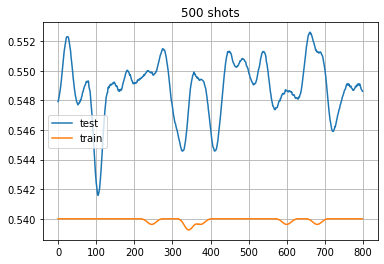

In [16]:
window_length = 50
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.title('{} shots'.format(train_shots))
plt.legend(["test", "train"])
plt.grid()
# x = np.arange(0, len(training), 1)
# plt.plot(x, training, testing)
# plt.legend(["test", "train"])
# plt.title('{} shots'.format(train_shots))
# plt.grid()